# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
import sagemaker
import boto3
import shutil
import os
import glob
import json
import math
%matplotlib inline

In [2]:
!pip install shapely

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [4]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [5]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::011113936377:role/service-role/AmazonSageMaker-ExecutionRole-20181024T095377


### Permission setup for Sagemaker to S3 bucket

The sagemaker wants to download simtrace from S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [6]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AmazonSageMakerFullAccess")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20181024T095377](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20181024T095377).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonSageMakerFullAccess` policy


### Permission setup for Sagemaker to fetch appropriate robomaker jobs

The sagemaker wants to know which robomaker simtrace job you want to download. This requires Robomaker service permission. Make sure the sagemaker role you are using as this permissions.

In [7]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AWSRoboMakerFullAccess")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20181024T095377](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20181024T095377).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AWSRoboMakerFullAccess` policy


## Download the desired log file given the simulation ID 

#### Change this to your robomaker simulation job name

In [8]:
simulation_name = 'sim-9jcxhkjccydt' ## CHANGE This to your simulation application job name

#### Initializing the required variables to download from S3 all the required variables

In [9]:
robomaker = boto3.client('robomaker')
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']
region = boto3.Session().region_name
robomaker_job_arn = "arn:aws:robomaker:{}:{}:simulation-job/{}".format(region, account_id, simulation_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(simulation_name)
if os.path.exists(merged_simtrace_path):
    os.remove(merged_simtrace_path)
shutil.rmtree('./tmp') if os.path.exists('./tmp') else os.mkdir('./tmp')

#### Download simtrace from S3

In [10]:
import json
# Get all the infro
job_desc = robomaker.describe_simulation_job(job=robomaker_job_arn)

#print(job_desc['simulationApplications'][0]['launchConfig']['environmentVariables'])
is_training = job_desc['simulationApplications'][0]['launchConfig']['launchFile'] == "distributed_training.launch"
#print(job_desc['simulationApplications'][0]['launchConfig']['environmentVariables'])
s3_bucket=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['SAGEMAKER_SHARED_S3_BUCKET']
s3_prefix=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['SAGEMAKER_SHARED_S3_PREFIX']
#s3_bucket = job_desc['outputLocation']['s3Bucket']
#s3_prefix = job_desc['outputLocation']['s3Prefix']
job_type = "training" if is_training else "evaluation"
#simtrace_path = "iteration-data/{}/".format(job_type)


logs=boto3.client('logs')
with open(merged_simtrace_path,"w") as fh:
    fh.write("episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status\n")
    paginator = logs.get_paginator('filter_log_events')
    for page in paginator.paginate(logGroupName='/aws/robomaker/SimulationJobs',logStreamNamePrefix=simulation_name):
        for event in page["events"]:
            if event['message'][:14]=="SIM_TRACE_LOG:":
                fh.write(event['message'][14:]+'\n')

# Downlaod all the simtrace iteration data
#!aws s3 sync s3://{s3_bucket}/{s3_prefix}/{simtrace_path} ./tmp --exclude "*" --include "*-{job_type}-simtrace.csv"


#### Merge all the csv files into one big .csv file

In [11]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)

#merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

619,72,4.1426,2.0403,30.6603,30.00,0.33,6,0.0003,False,False,17.8430,21,17.43,1585773792.3643947,in_progress
619,73,4.1849,2.0717,32.2511,0.00,1.00,5,0.0010,False,False,18.0601,21,17.43,1585773792.4306438,in_progress
619,74,4.2323,2.1090,34.2913,30.00,0.67,7,0.0005,True,False,18.0856,21,17.43,1585773792.4974298,off_track


## Load waypoints for the track you want to run analysis on


In [12]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['H_track.npy', 'reInvent2019_track.npy', 'Oval_track.npy', 'Canada_Training.npy', 'China_track.npy', 'reinvent_base.npy', 'New_York_Track.npy', 'London_Loop_Train.npy', 'AWS_track.npy', 'LGSWide.npy', 'AmericasGeneratedInclStart.npy', 'reInvent2019_wide_mirrored.npy', 'ChampionshipCup2019_track.npy', 'Tokyo_Training_track.npy', 'Straight_track.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'reInvent2019_wide.npy', 'FS_June2020.npy', 'Spain_track.npy', 'Bowtie_track.npy', 'Vegas_track.npy']


In [13]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

trackname=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['WORLD_NAME']

waypoints = get_track_waypoints(trackname) 
waypoints.shape

(163, 6)

## Visualize the Track and Waypoints

In [14]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

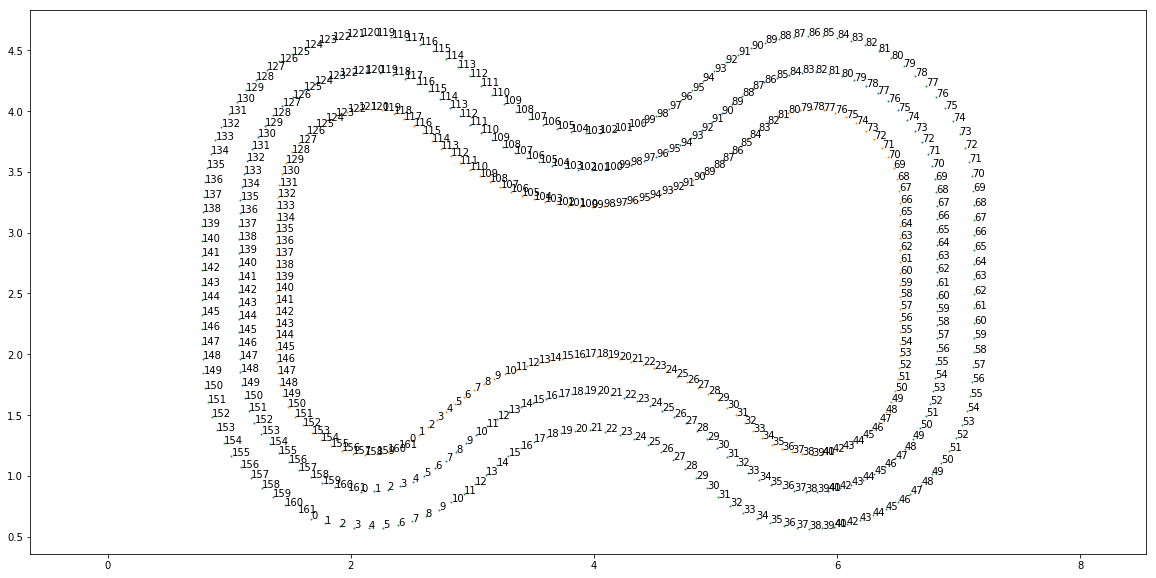

In [15]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

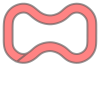

In [16]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [17]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [46]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
        #plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [19]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [20]:
TRAINING_ITERATION = 20

In [21]:
print(merged_simtrace_path)
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

./logs/deepracer-sim-9jcxhkjccydt.csv


,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1,2.2246,0.8719,0.4987,30.0,0.33,6,0.2667,False,True,0.8021,1,17.43,1.585766e+09,in_progress,1
1,0,2,2.2287,0.8721,0.5795,30.0,1.00,8,0.8000,False,True,0.8257,1,17.43,1.585766e+09,in_progress,1
2,0,3,2.2497,0.8743,1.3963,0.0,0.67,4,0.6667,False,True,0.9465,2,17.43,1.585766e+09,in_progress,1
3,0,4,2.2779,0.8772,2.2123,30.0,0.67,7,0.5333,False,True,1.1091,2,17.43,1.585766e+09,in_progress,1
4,0,5,2.3200,0.8836,3.7066,30.0,1.00,8,0.8000,False,True,1.3500,2,17.43,1.585766e+09,in_progress,1


In [22]:
df['y'].min(), df['x'].max()

(0.3869, 7.2981)

In [23]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [24]:
df['reward'].min(), df['reward'].max()

(0.0, 0.9999999999999999)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  619


Text(0.5, 0, 'Episode')

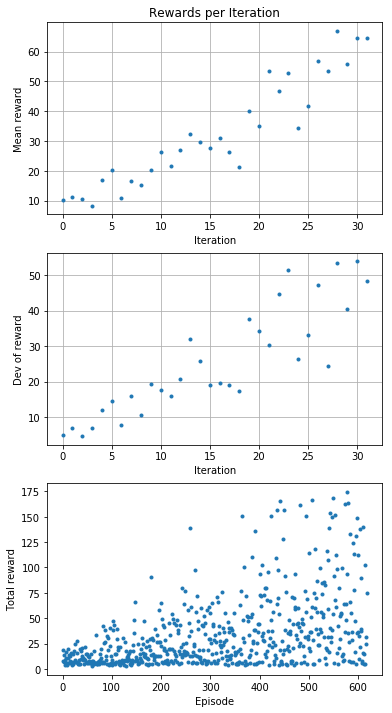

In [25]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == TRAINING_ITERATION - 1:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze the reward distribution for your reward function

In [26]:
# add y_offset to bring everything to the positive axis

# y_offset = int(df['y'].min())
# if y_offset > 0: # if positive, just keep it the same
#     y_offset = 0
# y_offset = abs(y_offset)

# inner_border[:,1] = inner_border[:,1] + y_offset
# center_line[:,1] = center_line[:,1] + y_offset
# outer_border[:,1] = outer_border[:,1] + y_offset

In [27]:
#NOTE: For the Tokyo track use this dimentions

#track = plot_track(df, track_size=(700, 1000), x_offset=0, y_offset=y_offset)
#plt.title("Reward distribution for all actions ")
#im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

In [28]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis 0.6061; Max x-axis 7.2981
Min y-axis 0.3869; Max y-axis 4.8072


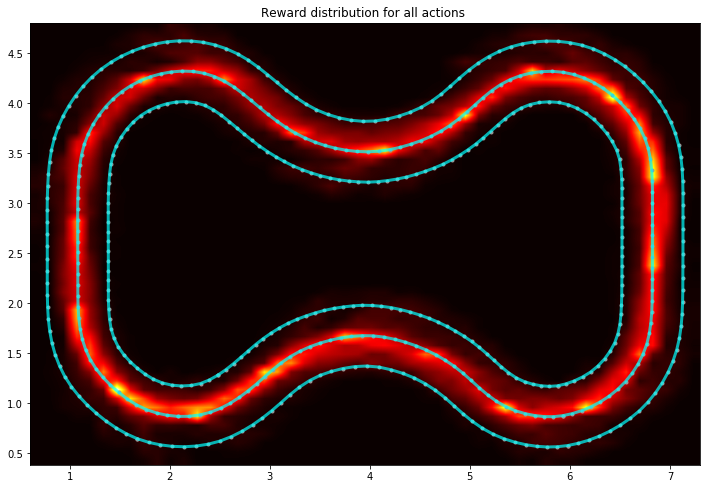

In [47]:
heatmapT,extent = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")

im = plt.imshow(heatmapT, cmap='hot',extent=extent, interpolation='bilinear', origin='lower')
#im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower")

### Plot a particular iteration


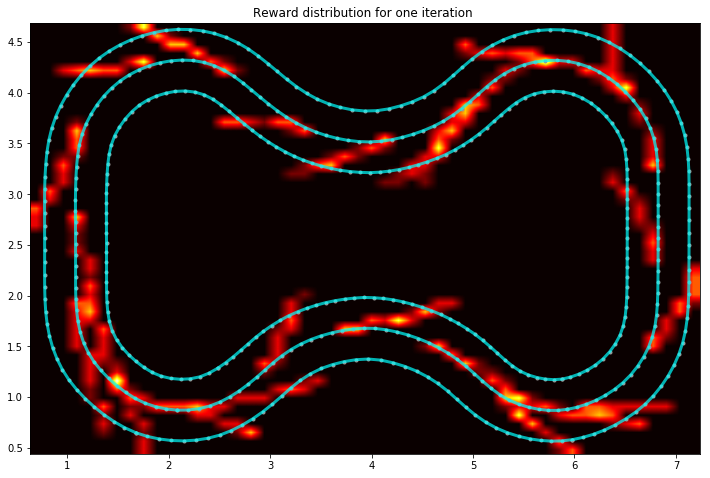

In [45]:
iteration_id = 4
heatmapT,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for one iteration ")
im = plt.imshow(heatmapT, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

In [ ]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [ ]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

In [ ]:
plot_episode_run(df, E=125) # arbitrary episode

### Path taken in a particular Iteration

In [ ]:
iteration_id = 4

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

In [ ]:
fig = plt.figure(figsize=(16, 24))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

# Track Segment Labels
action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [10,25,32,33,40,45,50,53,61,67]
track_segments = [(15, 100, 'hairpin'),
                  (32, 100, 'right'),
                  (42, 100, 'left'),
                  (51, 100, 'left'),
                  (63, 100, 'left')]

segment_x = np.array([15, 32, 42, 51, 63])
segment_y = np.array([0, 0, 0, 0, 0])

segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    th = 0.8
    for idx in range(len(action_names)):
        ax = fig.add_subplot(6, 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1]+20, str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(6, 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, 150))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [ ]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [ ]:
!rm intermediate_checkpoint/*
!aws s3 sync s3://{s3_bucket}/{s3_prefix}/model/ intermediate_checkpoint/ --exclude "*" --include "*model_*"

boto3_sagemaker=boto3.client('sagemaker')
training_job_arn=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['TRAINING_JOB_ARN']
paginator=boto3_sagemaker.get_paginator('list_training_jobs')
trainingjob=None
for page in paginator.paginate():
    for summary in page["TrainingJobSummaries"]:
        response=boto3_sagemaker.describe_training_job(TrainingJobName=summary['TrainingJobName'])
        #print(s3_bucket,response["HyperParameters"]["s3_bucket"])
        if "HyperParameters" in response and "s3_bucket" in response["HyperParameters"] and response["HyperParameters"]["s3_bucket"]==s3_bucket and response["HyperParameters"]["s3_prefix"]==s3_prefix:
            trainingjob=response
            break
    if trainingjob is not None:
        break
#print(trainingjob)
s3outputpath=trainingjob['OutputDataConfig']['S3OutputPath']
trainingjobname=trainingjob['TrainingJobName']

!aws s3 cp {s3outputpath}{trainingjobname}/output/model.tar.gz intermediate_checkpoint/
!tar zxvf intermediate_checkpoint/model.tar.gz -C intermediate_checkpoint/ \*.csv model_metadata.json

In [ ]:
## For this example lets download all models in interation in the 30s

## NOTE: Copy the variables from the output of the grep command
#!aws s3 sync s3://{s3_bucket}/{s3_prefix}/model/ intermediate_checkpoint/ --exclude "*" --include "*model_3*"

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # Different tensor names observation, 'FRONT_FACING_CAMERA', 'STEREO_CAMERAS'
    # For stereo cameras use the below
    # x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/STEREO_CAMERAS/STEREO_CAMERAS:0')
    # y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    # For front cameras use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
!ls $GRAPH_PB_PATH

In [ ]:
model_inference = []


iterations = []
onlyfiles = [f for f in listdir(GRAPH_PB_PATH) if isfile(join(GRAPH_PB_PATH, f))]
print(onlyfiles)
for file in onlyfiles:
    if file[:6]=="model_" and file[-3:]==".pb":
        iterations.append(int(file[6:-3]))

for ii in [max(iterations)]:
    model, obs, model_out = load_session(GRAPH_PB_PATH + 'model_%s.pb' % ii)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

In [ ]:
prob_diff = []

for mi in model_inference[0]:
    max1, max2 = mi.argsort()[-2:][::-1]
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff)

model 36 appears to have a better seperation in probabability, hence may work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [ ]:
fname = 'intermediate_checkpoint/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname)

In [ ]:
df_csv.columns

In [ ]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

In [ ]:
df_csv['Episode Length'].plot()

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [ ]:
simulation_name = 'sim-k3sdd951txdk' ## CHANGE This to your evaluation application job name

In [ ]:
robomaker = boto3.client('robomaker')
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']
region = boto3.Session().region_name
robomaker_job_arn = "arn:aws:robomaker:{}:{}:simulation-job/{}".format(region, account_id, simulation_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(simulation_name)
if os.path.exists(merged_simtrace_path):
    os.remove(merged_simtrace_path)
shutil.rmtree('./tmp') if os.path.exists('./tmp') else os.mkdir('./tmp')

#### Download simtrace from S3 eval metrics

In [ ]:
# Get all the infro
job_desc = robomaker.describe_simulation_job(job=robomaker_job_arn)

is_training = job_desc['simulationApplications'][0]['launchConfig']['launchFile'] == "distributed_training.launch"
#s3_bucket = job_desc['outputLocation']['s3Bucket']
#s3_prefix = job_desc['outputLocation']['s3Prefix']
job_type = "training" if is_training else "evaluation"
simtrace_path = "iteration-data/{}/".format(job_type)


s3_bucket=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['MODEL_S3_BUCKET']
s3_prefix=job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['MODEL_S3_PREFIX']

logs=boto3.client('logs')
with open(merged_simtrace_path,"w") as fh:
    fh.write("episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status\n")
    paginator = logs.get_paginator('filter_log_events')
    for page in paginator.paginate(logGroupName='/aws/robomaker/SimulationJobs',logStreamNamePrefix=simulation_name):
        #print(page["events"])
        for event in page["events"]:
            if event['message'][:14]=="SIM_TRACE_LOG:":
                fh.write(event['message'][14:]+'\n')

# Downlaod all the simtrace iteration data
#!aws s3 sync s3://{s3_bucket}/{s3_prefix}/{simtrace_path} ./tmp --exclude "*" --include "*-{job_type}-simtrace.csv"

In [ ]:
!tail -n 3 $merged_simtrace_path

In [ ]:
eval_df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(eval_df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
eval_df['iteration'] = np.digitize(eval_df.episode, iteration_arr)
eval_df = eval_df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
eval_df.head()

## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

In [ ]:
N_EPISODES = 2 
for e in range(N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = eval_df[eval_df['episode'] == e]
    plot_grid_world(episode_df, inner_border, outer_border, scale=0.5)
    print ("###############################################################\n\n")


## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_4/Conv2D:0')
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [ ]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [ ]:
model_path = GRAPH_PB_PATH + 'model_%i.pb'%(max(iterations)) #Change this to the desired 'pb' frozen graph file

action_space=json.load(open(GRAPH_PB_PATH+"model_metadata.json","r"))["action_space"]
print(action_space)

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_space))
    heatmaps.append(heatmap)
tf.reset_default_graph()

In [ ]:
plt.imshow(heatmaps[2])